In [3]:
import matplotlib.pylab as plt
import seaborn as sns
import re
import os
sns.despine()
import keras.layers
from backtest import *
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers
import pandas as pd
import theano
import datetime
import numpy as np
theano.config.compute_test_value = "ignore"


Using TensorFlow backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [19]:
def unix_to_datetime(data, column):
    for i in data[column]:
        dt = datetime.datetime.fromtimestamp(int(i)/1000).strftime('%y-%m-%d %H:%M:%S')
        #print(dt)
   # print(data[column].head())
    data[column] = dt
    return data

def get_last_time():
    return 0

def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

def get_latest():
    full_data = pd.read_csv('/home/me/Documents/binance_concat.csv') #bw_data/AIONBTC.csv')
    full_labels = pd.read_csv('/home/me/Documents/binance_sym_labels.csv')
    end = int(len(full_data))-2880
    last = full_data[end:]
    last_sym = full_labels
    print(last_sym["0"].iloc[len(last_sym)-1])
    return last, last_sym
#last, last_sym = get_latest()
#print(last)

def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))
def normalize(x):
    X = []
    for i in x:
        
        x =x.divide(x.iloc[0]).multiply(100)
    print(len(x))
    #minmax
    #X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X]
    return float(x)

In [38]:
"""bws = os.listdir('/home/me/Documents/bw_data/')
bw_coins = {}
for i in bws:
    if(hasNumbers(i)==False):
        i = i.replace(".csv","")
        bw_coins[i] = 0
    elif(hasNumbers(i)):
        i = i.replace(".csv","")
        i=i.split()
        bw_coins[i]=c
print(bw_coins)      """  

    
full_data = pd.read_csv('/home/me/Documents/binance_concat.csv') #bw_data/AIONBTC.csv')
full_labels = pd.read_csv('/home/me/Documents/binance_sym_labels.csv')
print(len(full_data), len(full_labels))
num_read = 3

data = {}
norm_close = [0]
for i in range(1,num_read+1):
    start = (i-1)*2880
    end= i*2880
    print("Adding {} to train data...".format(full_labels["0"].loc[i]))
    curr = full_data[start:end]
    #concat_data["norm close"] = norm_close
    curr["Norm Close"] = curr["Close"].divide(curr["Close"].iloc[0]).multiply(100)
    norm_close.append(normalize(curr["Close"].divide(curr["Close"].iloc[0]).multiply(100)))
    data[full_labels["0"].iloc[i]] = curr
concat_data = full_data[:end]
print(len(concat_data), len(norm_close))
#print(concat_data.columns, int(len(concat_data["Open"]))/2880)
del full_data
data_syms = list(data.keys())
#print(concat_data["Close"])

627840 218
Adding MODBTC to train data...
Adding WTCBTC to train data...
Adding BCDBTC to train data...
8640 4


/home/me/catalyst-venv/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
price = concat_data["Open"]
high = concat_data["High"]
low = concat_data["Low"]
close = concat_data["Close"]
volume = concat_data["Volume"]
dt = concat_data["Open time"]
buy_btc = concat_data["buyBtc"]
buy_sym = concat_data["buySym"]
x=close



0    0.000286
1    0.000285
2    0.000285
3    0.000285
4    0.000285
Name: Close, dtype: float64


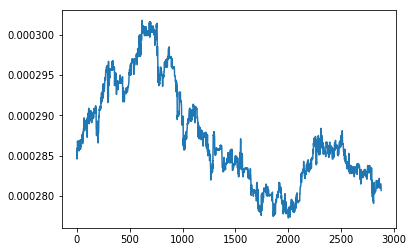

9


In [29]:
data = pd.read_csv('/home/me/Documents/BWA/data/bw_data/AIONBTC1.csv')
#print(data.columns)
try:
    data = unix_to_datetime(dt,'Open time')
    #data = unix_to_datetime(dt,'Close time')
    #print(data.head())
except Exception as e:
    print(e)
data = data.ix[:, 'Close']#.tolist()
print(data.head())

# Uncomment below to use price change time series
# data = data.ix[:, 'Adj Close'].pct_change().dropna().tolist()

plt.plot(data)
plt.show()

WINDOW = 10
EMB_SIZE = 1
STEP = 1
FORECAST = 5

# Straightforward way for creating time windows
X, Y = [], []
for i in range(0, len(data), STEP): 
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i
        #create binary price signals
        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

    except Exception as e:
        print(e)
        break

    X.append(x_i)
    Y.append(y_i)

X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X] # comment it to remove normalization
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

In [ ]:
model = Sequential()
#model.add(LSTM(32))
model.add(Dense(64, input_dim=5,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dropout(0.5))
model.add(Dense(16))
                #activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('softmax'))

opt = Nadam(lr=0.01)

#reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="./MODELS/test.hdf5", verbose=1, save_best_only=True)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 500, 
          batch_size = 60, 
          verbose=0, 
          validation_data=(X_test, Y_test))
          #callbacks=[reduce_lr, checkpointer],
          #shuffle=False)

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(np.array(X_test))
C = confusion_matrix([np.argmax(y) for y in Y_test], [np.argmax(y) for y in pred])

print (C / C.astype(np.float).sum(axis=1))

FROM = 0
TO = FROM + 500

original = Y_test[FROM:TO]
predicted = pred[FROM:TO] 
print(Y_test)
plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend(loc='best')
plt.title('Actual and predicted from point %d to point %d of test set' % (FROM, TO))
plt.show()

In [ ]:
if np.argmax(pred) == 0 and not self.long_market:
    self.long_market = True
    signal = SignalEvent(1, sym, dt, 'LONG', 1.0)
    self.events.put(signal)
    print(pred, 'LONG')
if np.argmax(pred) == 1 and self.long_market:
    self.long_market = False
    signal = SignalEvent(1, sym, dt, 'EXIT', 1.0)
    self.events.put(signal)
    print(pred, 'EXIT')